# importing required library

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# import the dataset from repo

In [61]:
file_1="Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

# cleaning dataset

In [62]:
C_max=2

#renaming columns for simplicity
dataset.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset["current_load"]= abs(dataset["current_load"])

In [63]:
#removing ideling / starting and ending current level data  

df=dataset[(dataset.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour

df["time"]=df["time"]/3600

# calculating Depth of discharge

In [64]:
#calculate DOD for each cycle
cycle_count=df["cycle"].unique()
DOD_list=[]
# Update DOD for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_DOD = [2.0]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_DOD.append(cumulative_DOD[-1] -delta_charge)
        
    DOD_list.extend(cumulative_DOD)
#DOD is the opposite of the soc 
DOD = [(q / C_max) for q in DOD_list]

df["DOD"]=DOD

In [65]:
test_data=[40,41,50,60,70,80,90,100,110,120,130,140,150,160]
train_data=[x for x in cycle_count if x not in test_data]

In [66]:
X_train = df[df['cycle'].isin(train_data)]
X_test = df[df['cycle'].isin(test_data)]

In [67]:
tp=['cycle','voltage', 'current','temperature', 'current_load', 'voltage_load',"time","DOD"]
ip=["time","DOD","temperature"]
op="voltage_load"
y_train=X_train.pop(op)
X_train=X_train[ip]

# Training The Random Forest Regressor Model

In [68]:
#making models
rfr_model = RandomForestRegressor(n_estimators=100,random_state=0)
rfr_model.fit(X_train,y_train.values.ravel())

RandomForestRegressor(random_state=0)

In [69]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [70]:
def DOD_plot_rfr(cycle_no):
    # Filter data for the specified cycle
    cycle_data = df[df['cycle'] == cycle_no].copy()

    # Separate features (X) and target variable (y)
    X = cycle_data[ip]
    y = cycle_data[op]


    # Make predictions on the test set
    y_pred = rfr_model.predict(X)

    # Calculate mean squared error on the test set
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred ))
    mape = MAPE(y,y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f"MAPE : {mape}")
    
    # Plot the actual vs predicted SOC
    plt.figure(figsize=(5.1, 2.5))
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.grid(linestyle=' ')
    plt.ylabel(op)
    plt.xlabel('DOD')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.yticks([0,1,2,3,4,5])
    plt.scatter(X["DOD"] , y, color='red', label='Measured Terminal Voltage',s=10)
    plt.scatter(X["DOD"] , y_pred, color='blue', label='Predicted Terminal Voltage',s=1)
    plt.title(f'Random forest regressor_node(100) (Cycle {cycle_no})',fontweight="bold",fontsize="10")
    plt.legend(loc="lower right",fontsize="8")
    plt.show()

cycle no = 40
Root Mean Squared Error: 0.02339388486266351
MAPE : 0.006244698312203334


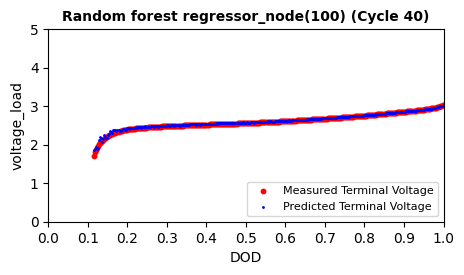

cycle no = 41
Root Mean Squared Error: 0.03257394200328129
MAPE : 0.00954903061232356


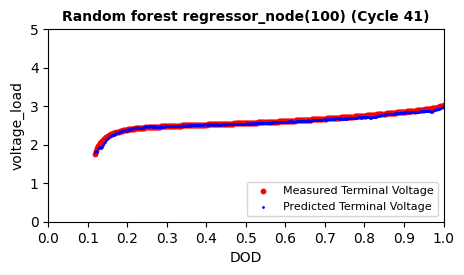

cycle no = 50
Root Mean Squared Error: 0.06995565500697992
MAPE : 0.02398630341961968


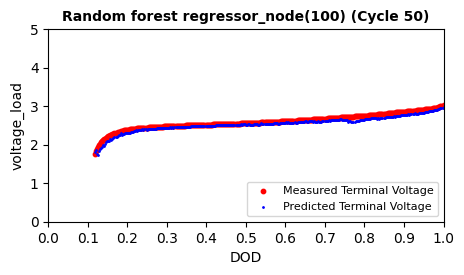

cycle no = 60
Root Mean Squared Error: 0.04031127864261412
MAPE : 0.0100157372994808


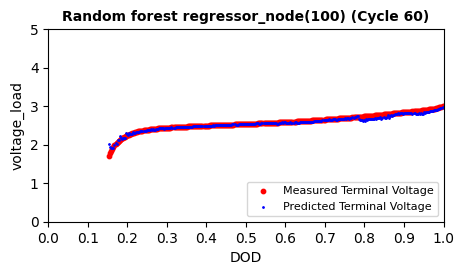

cycle no = 70
Root Mean Squared Error: 0.023543455593565243
MAPE : 0.004615047705717669


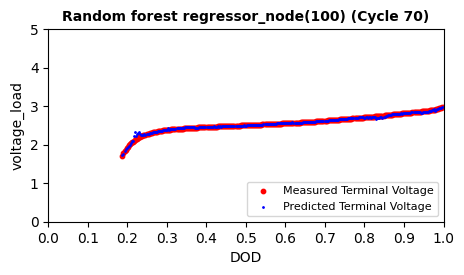

cycle no = 80
Root Mean Squared Error: 0.06262080765612182
MAPE : 0.02400926583866483


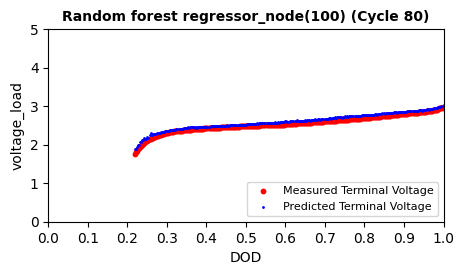

cycle no = 90
Root Mean Squared Error: 0.03805069441682534
MAPE : 0.010151659208304404


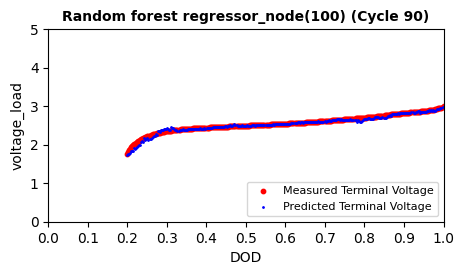

cycle no = 100
Root Mean Squared Error: 0.013483260735831762
MAPE : 0.0035850964672796996


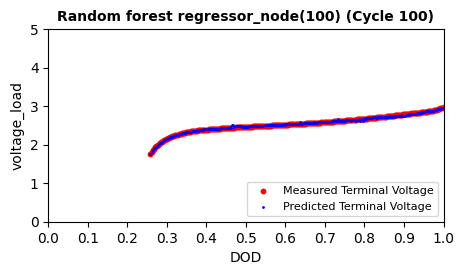

cycle no = 110
Root Mean Squared Error: 0.023506462273001988
MAPE : 0.008258394413670087


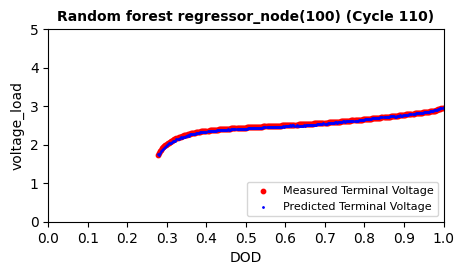

cycle no = 120
Root Mean Squared Error: 0.036355689591774126
MAPE : 0.012832473003039727


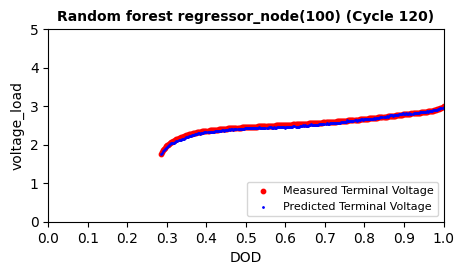

cycle no = 130
Root Mean Squared Error: 0.023750510167280733
MAPE : 0.007919092416601782


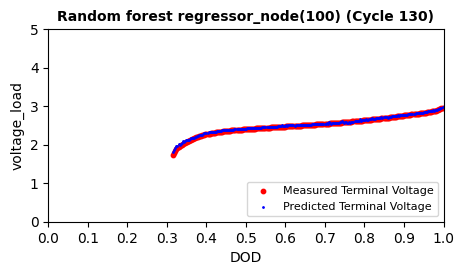

cycle no = 140
Root Mean Squared Error: 0.023394514587627143
MAPE : 0.007849138421235137


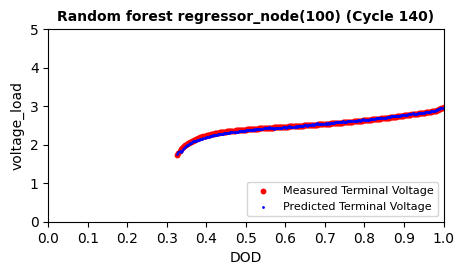

cycle no = 150
Root Mean Squared Error: 0.06170555083262215
MAPE : 0.023134340653545995


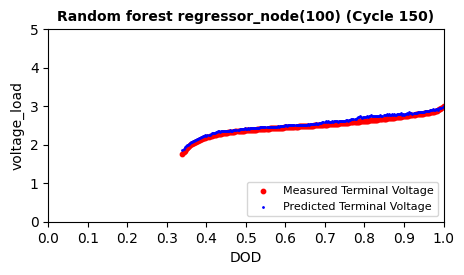

cycle no = 160
Root Mean Squared Error: 0.04235146467645432
MAPE : 0.0159070717418418


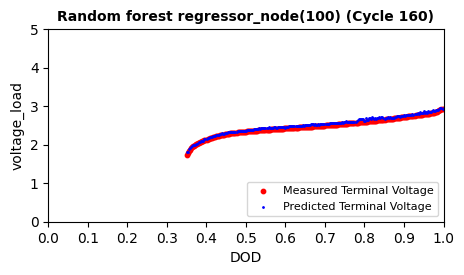

In [71]:
for i in test_data:
    print(f"cycle no = {i}")
    DOD_plot_rfr(i)